# Packages and Data

In [1]:
!pip install segmentation_models_pytorch -q
import segmentation_models_pytorch as smp

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from torch import nn, optim
from PIL import Image
import math
import torch.nn.functional as F
from torch.nn import Parameter
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
file_dir  = "../input/severstal-steel-defect-detection/train_images"
df = pd.read_csv("../input/severstal-steel-defect-detection/train.csv")

In [3]:
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
train = df[df["ClassId"]==3]

In [5]:
train

,ImageId,ClassId,EncodedPixels
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
11,0046839bd.jpg,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...
12,005d86c25.jpg,3,331 18 587 53 843 89 1099 124 1355 159 1611 17...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


# Data Channels

### The "rle2mask" get a array with form (first pixels position, number of pixels, first pixels position, number of pixels, ...) to 256*1600 numpy arrray which displays the position of defection in the image, where 1s mean defection, 0s mean no defection.

In [6]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros(width * height).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        
    return np.flipud(np.rot90(mask.reshape(height, width), k=1))

### For each image, I get two new images by flipping horizontally and vertically, and use them for training. Noticet that mask also require the same type of flipping. This is a kind of image augmentation, which can aviod overfitting and improve performance.

In [7]:
class PixelsDataset(Dataset):
    def __init__(self, df, file_dir, transform, label_flip = None):
        self.df = df
        self.file_dir = file_dir
        self.transform = transform
        self.label_flip = label_flip
    def __getitem__(self, index):
      
        image_name = self.df["ImageId"].iloc[index]
        image = cv2.imread(os.path.join(self.file_dir, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)["image"]
        
        pixels = self.df["EncodedPixels"].iloc[index]
        mask = rle2mask(pixels, (256,1600))
        if self.label_flip == "v":
            mask= np.flipud(mask).copy()
        elif self.label_flip == "h":
            mask= np.fliplr(mask).copy()
        return image, mask

    
    def __len__(self):
        return self.df.shape[0]

In [8]:
train_transform = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                            ToTensorV2()]
)
hf_transform = A.Compose([A.HorizontalFlip(p=1),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                            ToTensorV2()])
vf_transform = A.Compose([A.VerticalFlip(p=1),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                            ToTensorV2()])
val_transform = A.Compose([
                           A.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                           ToTensorV2()])

# Split Data

### I split data into 5 folds to train 5 models, pick the model with the best performance

In [9]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
fold1_idx, fold2_idx, fold3_idx, fold4_idx, fold5_idx = kf.split(train)
fold1 = train.iloc[fold1_idx[1]]
fold2 = train.iloc[fold2_idx[1]]
fold3 = train.iloc[fold3_idx[1]]
fold4 = train.iloc[fold4_idx[1]]
fold5 = train.iloc[fold5_idx[1]]

In [10]:
fold1.to_csv("class3_fold1.csv",index=False)
fold2.to_csv("class3_fold2.csv",index=False)
fold3.to_csv("class3_fold3.csv",index=False)
fold4.to_csv("class3_fold4.csv",index=False)
fold5.to_csv("class3_fold5.csv",index=False)

In [11]:
train = pd.concat((fold2, fold3, fold4, fold5), axis = 0)
val = fold1

In [12]:
train_data = PixelsDataset(train, file_dir, transform =train_transform)
hf_train_data = PixelsDataset(train, file_dir, transform =hf_transform, label_flip="h")
vf_train_data = PixelsDataset(train, file_dir, transform =vf_transform, label_flip="v")
val_data = PixelsDataset(val, file_dir, transform =val_transform)
train_data = torch.utils.data.ConcatDataset([train_data, hf_train_data, vf_train_data])

In [13]:
train_loader = DataLoader(train_data, batch_size = 8, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 8, shuffle=True)

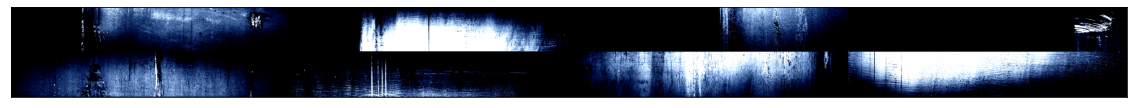

In [14]:
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

# Get Pretrained Model 

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### I use Unet here for training. Unet includes encoder and decoder two parts, encoder is the same as resnet18 without fully connect layers, decoder make the result of encoder back to a array with the same size of input image.

### Here I frozen the encoder layers for the transfer learning for the first 5 epochs.

In [16]:
model = smp.Unet('resnet18', encoder_weights='imagenet')
for p in model.encoder.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
model = model.to(device)
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Start Training

### Here I use 0.75 BCE Loss and 0.25 Dice Loss as the Loss Function. BCE Loss can give the probability of defection for each pixels and Dice Loss is the requirement of this competition.

In [18]:
class DiceCoefficient(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceCoefficient, self).__init__()

    def forward(self, inputs, targets, smooth=1e-9):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        Dice = 0
        #flatten label and prediction tensors
        for i in range(inputs.shape[0]):
            pred = inputs[i].view(-1)
            truth = targets[i].view(-1)
        
            intersection = (pred * truth).sum()                            
            Dice += (2.*intersection + smooth)/(pred.sum() + truth.sum() + smooth)
        
        return Dice.float()

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-7):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = 0.75*BCE + 0.25*dice_loss
        
        return Dice_BCE.float()

In [20]:
dice = DiceCoefficient()

In [21]:
criterion = DiceBCELoss()

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [23]:
def train_model(model, num_epochs, criterion, train_loader, val_loader, optimizer, dice):    

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        train_dice = 0
        train_total = 0
        model.train()
        running_loss = 0

        for images, labels in tqdm(train_loader):

            images = images.to(device).float()
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            train_dice += dice(outputs, labels).item()
            train_total += labels.size(0)
            
        train_dice = train_dice/train_total
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_dice = 0
        val_total = 0
        running_loss = 0
        
        with torch.no_grad():  
            for images, labels in tqdm(val_loader):

                images = images.to(device).float()
                labels = labels.to(device).float()

                optimizer.zero_grad()
                outputs = model(images)

                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                val_dice += dice(outputs, labels).item()
                val_total += labels.size(0)
            
        val_dice = val_dice/val_total
        val_losses.append(running_loss / len(val_loader))

        print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train Dice: %.6f], [Val Dice: %.6f]" \
              %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_dice, val_dice))

In [24]:
train_model(model, 5, criterion, train_loader,val_loader, optimizer, dice)

100%|██████████| 129/129 [00:45<00:00,  2.84it/s]


[Epoch: 1 / 5], [Trian loss: 0.428175], [Val loss: 0.238633], [Train Dice: 0.218017], [Val Dice: 0.330294]


100%|██████████| 129/129 [00:38<00:00,  3.36it/s]


[Epoch: 2 / 5], [Trian loss: 0.199369], [Val loss: 0.167642], [Train Dice: 0.439171], [Val Dice: 0.519188]


100%|██████████| 129/129 [00:38<00:00,  3.37it/s]


[Epoch: 3 / 5], [Trian loss: 0.163257], [Val loss: 0.156132], [Train Dice: 0.551732], [Val Dice: 0.565249]


100%|██████████| 129/129 [00:39<00:00,  3.29it/s]


[Epoch: 4 / 5], [Trian loss: 0.151904], [Val loss: 0.154158], [Train Dice: 0.594935], [Val Dice: 0.601100]


100%|██████████| 129/129 [00:38<00:00,  3.36it/s]

[Epoch: 5 / 5], [Trian loss: 0.144178], [Val loss: 0.149258], [Train Dice: 0.615447], [Val Dice: 0.624658]


### Here I unfrozen encoder layers.

In [25]:
for p in model.parameters():
    p.requires_grad = True

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [27]:
train_model(model, 5, criterion, train_loader,val_loader, optimizer, dice)

100%|██████████| 129/129 [00:39<00:00,  3.25it/s]


[Epoch: 1 / 5], [Trian loss: 0.132084], [Val loss: 0.138410], [Train Dice: 0.642461], [Val Dice: 0.633482]


100%|██████████| 129/129 [00:40<00:00,  3.19it/s]


[Epoch: 2 / 5], [Trian loss: 0.121679], [Val loss: 0.137171], [Train Dice: 0.664139], [Val Dice: 0.643145]


100%|██████████| 129/129 [00:39<00:00,  3.26it/s]


[Epoch: 3 / 5], [Trian loss: 0.112198], [Val loss: 0.138162], [Train Dice: 0.683800], [Val Dice: 0.649834]


100%|██████████| 129/129 [00:38<00:00,  3.32it/s]


[Epoch: 4 / 5], [Trian loss: 0.103564], [Val loss: 0.137546], [Train Dice: 0.700387], [Val Dice: 0.652009]


100%|██████████| 129/129 [00:39<00:00,  3.24it/s]

[Epoch: 5 / 5], [Trian loss: 0.096938], [Val loss: 0.140758], [Train Dice: 0.716135], [Val Dice: 0.665156]


In [28]:
train_model(model, 5, criterion, train_loader,val_loader, optimizer, dice)

100%|██████████| 129/129 [00:39<00:00,  3.28it/s]


[Epoch: 1 / 5], [Trian loss: 0.089938], [Val loss: 0.139940], [Train Dice: 0.730402], [Val Dice: 0.662562]


100%|██████████| 129/129 [00:37<00:00,  3.44it/s]


[Epoch: 2 / 5], [Trian loss: 0.084601], [Val loss: 0.143642], [Train Dice: 0.742811], [Val Dice: 0.665420]


100%|██████████| 129/129 [00:37<00:00,  3.40it/s]


[Epoch: 3 / 5], [Trian loss: 0.079321], [Val loss: 0.145301], [Train Dice: 0.755558], [Val Dice: 0.672590]


100%|██████████| 129/129 [00:38<00:00,  3.37it/s]


[Epoch: 4 / 5], [Trian loss: 0.074290], [Val loss: 0.147925], [Train Dice: 0.764841], [Val Dice: 0.668898]


100%|██████████| 129/129 [00:37<00:00,  3.40it/s]

[Epoch: 5 / 5], [Trian loss: 0.071030], [Val loss: 0.148659], [Train Dice: 0.774312], [Val Dice: 0.672205]


In [29]:
train_model(model, 2, criterion, train_loader,val_loader, optimizer, dice)

100%|██████████| 129/129 [00:37<00:00,  3.44it/s]


[Epoch: 1 / 2], [Trian loss: 0.067278], [Val loss: 0.149371], [Train Dice: 0.783685], [Val Dice: 0.672935]


100%|██████████| 129/129 [00:38<00:00,  3.36it/s]

[Epoch: 2 / 2], [Trian loss: 0.064106], [Val loss: 0.152485], [Train Dice: 0.791698], [Val Dice: 0.671022]


In [30]:
train_model(model, 2, criterion, train_loader,val_loader, optimizer, dice)

100%|██████████| 129/129 [00:38<00:00,  3.32it/s]


[Epoch: 1 / 2], [Trian loss: 0.061053], [Val loss: 0.151363], [Train Dice: 0.800061], [Val Dice: 0.680491]


100%|██████████| 129/129 [00:37<00:00,  3.41it/s]

[Epoch: 2 / 2], [Trian loss: 0.058621], [Val loss: 0.155109], [Train Dice: 0.806926], [Val Dice: 0.681231]


In [31]:
train_model(model, 2, criterion, train_loader,val_loader, optimizer, dice)

100%|██████████| 129/129 [00:37<00:00,  3.45it/s]


[Epoch: 1 / 2], [Trian loss: 0.056457], [Val loss: 0.152611], [Train Dice: 0.812325], [Val Dice: 0.683378]


100%|██████████| 129/129 [00:39<00:00,  3.26it/s]

[Epoch: 2 / 2], [Trian loss: 0.054247], [Val loss: 0.153330], [Train Dice: 0.818978], [Val Dice: 0.687467]


# Save Model

In [33]:
torch.save(model, "class3_detector_fold1.h5")